In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Rescaling
from tensorflow import keras

In [2]:
tf.random.set_seed(42)
dataset_path = "/kaggle/input/aug-clean-dataset/aug_clean_dataset"
testset_path = "/kaggle/input/cleaned-testset/testset"
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path,
                                                      batch_size=32,
                                                      label_mode="int",
                                                      shuffle=True,
                                                      color_mode="grayscale",
                                                      class_names=['inme Yok_kronik surec_diger Veri Set_PNG', 'iskemi ve Kanama Veri Seti'])
testset = tf.keras.utils.image_dataset_from_directory(testset_path,
                                                      batch_size=32,
                                                      label_mode="int",
                                                      shuffle=False,
                                                      color_mode="grayscale",
                                                      class_names=["0_zero", "1_one"])
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)
print(dataset.class_names)  # Lists folder names as class labels
print(testset.class_names)

Found 6718 files belonging to 2 classes.
Found 179 files belonging to 2 classes.
['inme Yok_kronik surec_diger Veri Set_PNG', 'iskemi ve Kanama Veri Seti']
['0_zero', '1_one']


In [3]:
shape =()
for images, labels in train_ds.take(1):
    print("Train batch shape:", images.shape)
    print("Train labels shape:", labels.shape)
    shape = images.shape[1:]

Train batch shape: (32, 256, 256, 1)
Train labels shape: (32,)


In [4]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


In [5]:
with strategy.scope():
    model = keras.Sequential([
        Rescaling(1./255, input_shape=(shape)),
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
    
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
    
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.5),
    
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,953 (492.00 KB)

 Trainable params: 125,953 (492.00 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(train_ds, epochs=100, batch_size=32, validation_data=val_ds)
model.save('CNN_Model_100epochs.keras')

Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 45s 224ms/step - accuracy: 0.5258 - loss: 0.6871 - val_accuracy: 0.6364 - val_loss: 0.5924
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.6664 - loss: 0.5852 - val_accuracy: 0.7139 - val_loss: 0.5340
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 35s 205ms/step - accuracy: 0.7230 - loss: 0.5462 - val_accuracy: 0.7303 - val_loss: 0.5240
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.7223 - loss: 0.5408 - val_accuracy: 0.7914 - val_loss: 0.4781
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.7463 - loss: 0.5122 - val_accuracy: 0.7481 - val_loss: 0.5247
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 195ms/step - accuracy: 0.7637 - loss: 0.4967 - val_accuracy: 0.7928 - val_loss: 0.4535
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 197ms/step - accuracy: 0.7692 - loss: 0.4898 - val_accuracy: 0.7779 - val_loss: 0.4753
Epoch 8/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 33s 194ms/step - accuracy: 0.7807 -

In [8]:
model.save('/kaggle/working/CNN_Model_100epochs.keras')

In [9]:
def evaluate_model(model, testset):
    # Convert labels to float for compatibility
    test_ds = testset.map(lambda x, y: (x, tf.cast(y, tf.float32)))
    
    # Get true labels
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    
    # Get model predictions
    y_pred_prob = model.predict(test_ds)
    y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", conf_matrix)
    
    # Extract values from confusion matrix
    tn, fp, fn, tp = conf_matrix.ravel()
    
    # Compute performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(pd.DataFrame(conf_matrix), annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "auc_score": auc_score,
        "f1_score": f1
    }


Evaluating for the Valset:
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step
Confusion Matrix:
 [[335 324]
 [352 331]]
Accuracy: 0.4963
Precision: 0.5053
Recall (Sensitivity): 0.4846
Specificity: 0.5083
AUC Score: 0.4906
F1 Score: 0.4948


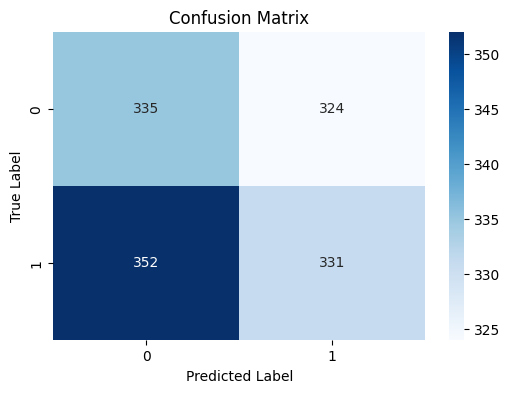

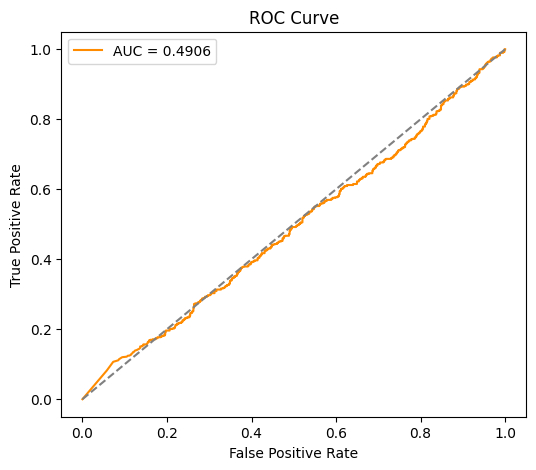

Evaluating for the Testset:
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
Confusion Matrix:
 [[108  11]
 [ 11  49]]
Accuracy: 0.8771
Precision: 0.8167
Recall (Sensitivity): 0.8167
Specificity: 0.9076
AUC Score: 0.9510
F1 Score: 0.8167


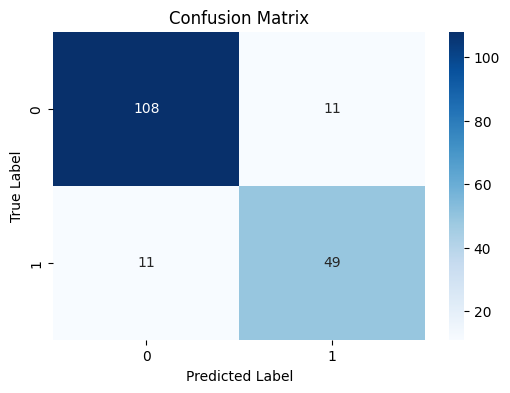

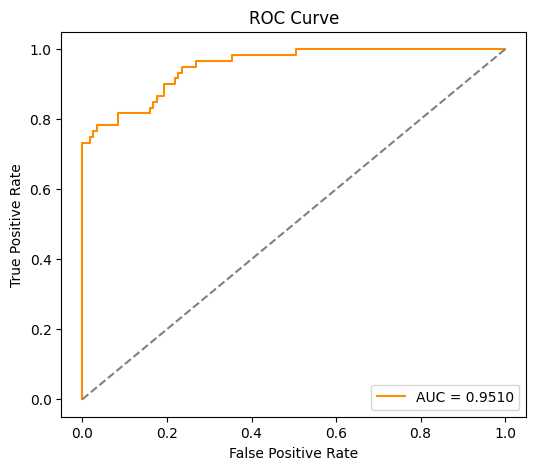

In [10]:
print("Evaluating for the Valset:")
val_evaluation = evaluate_model(model, val_ds)
print("Evaluating for the Testset:")
test_evaluation = evaluate_model(model, testset)

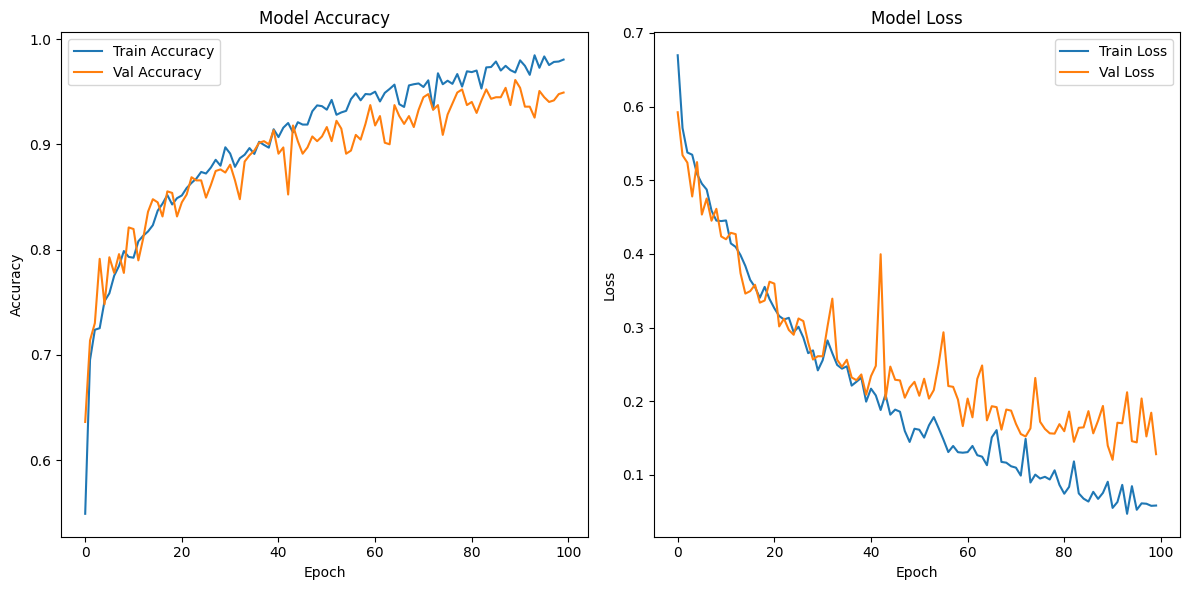

In [11]:

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
#plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')
#plt.scatter(100, test_accuracy, color='r', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
#plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Accuracy')
#plt.scatter(100, test_loss, color='r', label='Test Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()